In [1]:
print("HI")

HI


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import pprint
# from IPython.display import set_matplotlib_formats
from datasets import load_dataset

In [3]:
emotions_dataset = load_dataset("dair-ai/emotion")
print(emotions_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [4]:
emotions_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
emotions_dataset["train"].features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [6]:
emotions_dataset.set_format(type="pandas")
df = emotions_dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
df["label_name"] = df["label"].map(emotions_dataset["train"]
                              .features["label"].int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0.5, 1.0, 'Class Distributions')

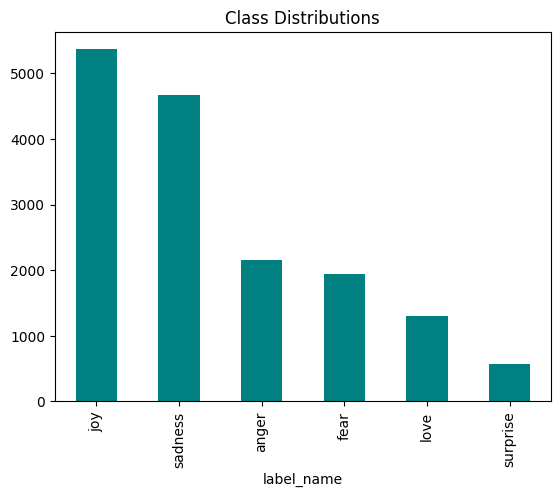

In [8]:
df["label_name"].value_counts().plot(kind="bar", color="teal")
plt.title("Class Distributions")

In [9]:
emotions_dataset.reset_format()

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

pprint.pprint(tokenize(emotions_dataset["train"][167:169]), compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]],
 'input_ids': [[101, 1045, 2031, 1037, 3110, 2026, 3193, 3475, 2102, 2183, 2000,
                2022, 2200, 2759, 1998, 2008, 2015, 2986, 102],
               [101, 1045, 2215, 2000, 2907, 2023, 3110, 1997, 7135, 15180,
                1998, 4687, 5091, 102, 0, 0, 0, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [12]:
encoded_emotions_ds = emotions_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
pprint.pprint(encoded_emotions_ds["train"].features, compact=True)

{'attention_mask': List(Value('int8')),
 'input_ids': List(Value('int32')),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear',
                            'surprise']),
 'text': Value('string'),
 'token_type_ids': List(Value('int8'))}


In [14]:
from transformers import AutoModel

model_checkpoint = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

In [15]:
def get_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [16]:
encoded_emotions_ds.set_format("torch",
                    columns=["input_ids", "attention_mask", "label"])

hidden_emotions_ds = encoded_emotions_ds.map(get_hidden_states, 
                                             batched=True)

hidden_emotions_ds["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [17]:
import numpy as np

X_train = np.array(hidden_emotions_ds["train"]["hidden_state"])
X_valid = np.array(hidden_emotions_ds["validation"]["hidden_state"])
y_train = np.array(hidden_emotions_ds["train"]["label"])
y_valid = np.array(hidden_emotions_ds["validation"]["label"])

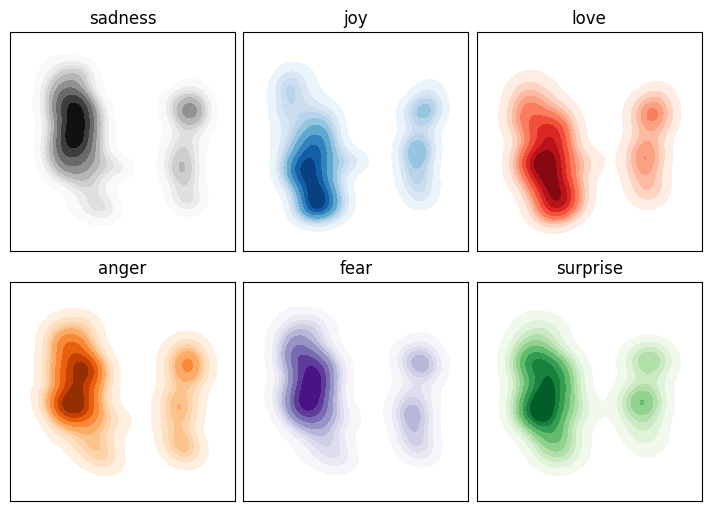

In [18]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
new_embed = pd.DataFrame(mapper.embedding_, columns=["X", "Y"]).assign(label=y_train)

fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         constrained_layout=True,
                         subplot_kw=dict(xticks=[], yticks=[], xlabel=None, ylabel=None))

axes = axes.flatten()

cmaps = ["Greys", "Blues", "Reds", "Oranges", "Purples", "Greens"]
labels = emotions_dataset["train"].features["label"].names

for label, cmap, ax in zip(labels, cmaps, axes):
    sns.kdeplot(data=new_embed.query(f"label=={labels.index(label)}"),
                x="X", y="Y", cmap=cmap, fill=True, ax=ax)

    ax.set_title(label)

plt.show()

In [19]:
from huggingface_hub import notebook_login
notebook_login()

In [22]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(set(emotions_dataset["train"].features["label"].names))

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device)

batch_size = 64

logging_steps = len(encoded_emotions_ds["train"]) // batch_size

model_name = f"BERT-finetuned-on-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=0.01,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_emotions_ds["train"],
    eval_dataset=encoded_emotions_ds["validation"],
    tokenizer=tokenizer
)

trainer.train()

C:\Users\shrey\AppData\Local\Temp\ipykernel_28092\2470411611.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\shrey\Documents\ANLP2\ftenv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,No log,1.730547,0.313500,0.243796


c:\Users\shrey\Documents\ANLP2\ftenv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3, training_loss=1.7660983403523762, metrics={'train_runtime': 125.0396, 'train_samples_per_second': 1.28, 'train_steps_per_second': 0.024, 'total_flos': 8584306470144.0, 'train_loss': 1.7660983403523762, 'epoch': 0.012})

In [24]:
trainer.save_model(model_name)     # saves model weights + config
tokenizer.save_pretrained(model_name)

print(f"✅ Model and tokenizer saved to '{model_name}'")

Upload 0 LFS files: 0it [00:00, ?it/s]

✅ Model and tokenizer saved to 'BERT-finetuned-on-emotion'
